In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [20]:
deaths_reported = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

cols = deaths_reported.keys()
deaths = deaths_reported.loc[:, cols[4]:cols[66]]
dates = deaths.keys()
world_cases = []

for i in dates:
    deaths_sum = deaths[i].sum()
    world_cases.append(deaths_sum)
  


days_since_1_22 = np.array([i for i in range(len(dates))])
#world_cases = np.array(world_cases).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [38]:
mycases=pd.DataFrame({"dates":days_since_1_22,"cases":world_cases})
mycases=mycases.set_index("dates")
len(mycases)
rolmean=pd.DataFrame(mycases['cases']).rolling(window=3).mean()
print(rolmean)

              cases
dates              
0               NaN
1               NaN
2         20.333333
3         28.666667
4         41.333333
...             ...
58     10101.666667
59     11539.666667
60     13164.666667
61     14944.333333
62     16911.000000

[63 rows x 1 columns]


In [23]:
rolmean['cases'].fillna(17, inplace=True)
print(rolmean['cases'].isnull().sum())


0


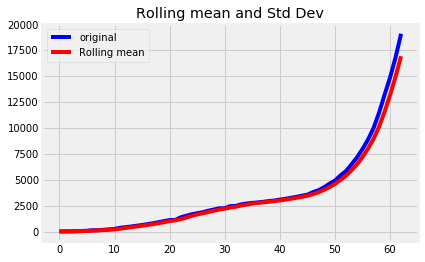

In [24]:
orig=plt.plot(mycases,color="blue",label="original")
mean=plt.plot(rolmean,color="red",label="Rolling mean")
plt.legend(loc="best")
plt.title("Rolling mean and Std Dev")
plt.show(block=False)

In [25]:
train_len = int(np.ceil(len(mycases) * 0.90))
print(len(mycases)-train_len)

6


In [26]:
train=rolmean[0:train_len] 
test=rolmean[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 57
Test  data length : 6


In [27]:
x_train = train.drop('cases', axis=1)
x_test = test.drop('cases', axis=1)
y_train = train[['cases']]
y_test = test[['cases']]


In [28]:
model = SimpleExpSmoothing(train['cases'])

In [29]:
for i in np.arange(0.1,1,0.1):
    model_fit = model.fit(smoothing_level=i,optimized=False)
    y_hat_avg = test.copy()
    y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))
    rmse = np.sqrt(mean_squared_error(test.cases, y_hat_avg.SES))
    rmse = round(rmse, 3)
    abs_error = np.abs(y_test['cases']-y_hat_avg.SES)
    actual = y_test['cases']
    mape = np.round(np.mean(abs_error/actual),4)
    print('smoothing_level : ',np.round(i,1),'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

smoothing_level :  0.1 RMSE :  8281.26 MAPE :  0.6015
smoothing_level :  0.2 RMSE :  7188.68 MAPE :  0.5042
smoothing_level :  0.3 RMSE :  6607.59 MAPE :  0.4514
smoothing_level :  0.4 RMSE :  6235.16 MAPE :  0.4171
smoothing_level :  0.5 RMSE :  5976.36 MAPE :  0.393
smoothing_level :  0.6 RMSE :  5786.57 MAPE :  0.3751
smoothing_level :  0.7 RMSE :  5641.74 MAPE :  0.3614
smoothing_level :  0.8 RMSE :  5527.8 MAPE :  0.3505
smoothing_level :  0.9 RMSE :  5436.02 MAPE :  0.3417


In [30]:
model_fit = model.fit(smoothing_level=0.9,optimized=True)
model_fit.params

{'smoothing_level': 0.9,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 17.045219834390185,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [31]:
y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))

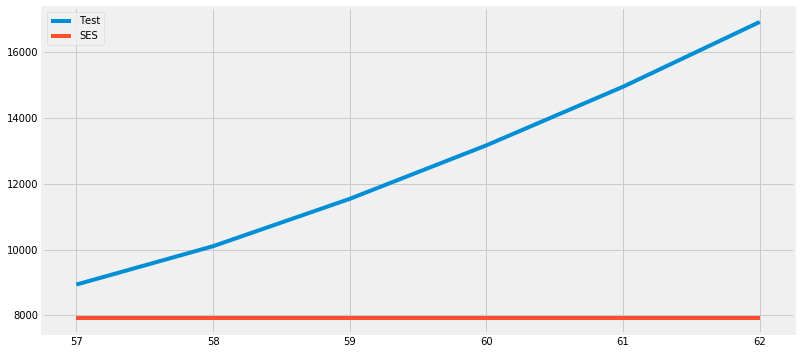

In [40]:
plt.figure(figsize=(12,6))
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')

In [33]:
from statsmodels.tsa.api import Holt
fit1 = Holt(np.asarray(train['cases']),exponential=True).fit(smoothing_level=1,smoothing_slope=1, optimized=False)
fit1.params

{'smoothing_level': 1.0,
 'smoothing_slope': 1.0,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 17.0,
 'initial_slope': 1.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [34]:
y_hat_avg['Holt'] = fit1.forecast(len(test))
print(y_hat_avg)

              cases         SES          Holt
dates                                        
57      8937.000000  7907.19724   8880.329999
58     10101.666667  7907.19724   9864.108683
59     11539.666667  7907.19724  10956.872113
60     13164.666667  7907.19724  12170.693810
61     14944.333333  7907.19724  13518.984825
62     16911.000000  7907.19724  15016.641907


In [35]:
#exponentialsmoothing
print('MAE:{}  || Actual Values: 406 '.format(mean_absolute_error(y_hat_avg['Holt'], test['cases'])))
print('MSE:{}  || Actual Values: 662228 '.format(mean_squared_error(y_hat_avg['Holt'], test['cases'])))

MAE:865.1169992956566  || Actual Values: 406 
MSE:1167914.628295597  || Actual Values: 662228 


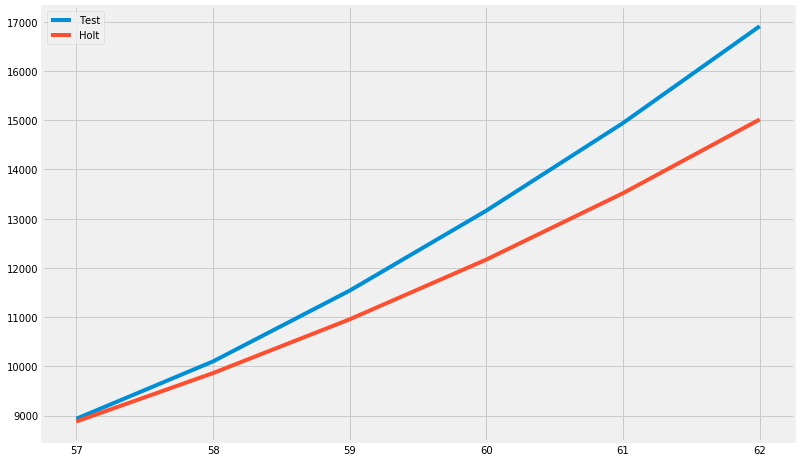

In [39]:
plt.figure(figsize=(12,8))
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()